# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

Extractive distillation of MethylCyloHexane/Toluene using Phenol adapted from [Tiverios and Van Brunt in Ind.Eng.Chem.Res. (2000) 39, pp. 1614-1623](http://pubs.acs.org/doi/pdf/10.1021/ie990654k)

[Link to flowsheet on ChemSep homepage](http://www.chemsep.org/downloads/data/CScasebook_MCHT.png)

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")
clr.AddReference(r"..\bin\MiniSim.FlowsheetDrawing")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes
from  MiniSim.Core.Flowsheeting.Documentation import SpreadsheetElement
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem
from  MiniSim.FlowsheetDrawing import FlowsheetDrawer, DrawingOptions

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

In [5]:
def calc(flowsheet, relax, maxIter):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    presolver.Solve(flowsheet)
    print (logger.Flush())
    
def decomp(flowsheet):
    solver= num.DecompositionSolver(logger)
    solver.Solve(flowsheet)
    print (logger.Flush())
    
def thermoAnalysis(psys):
    numComps=len(sys.Components)
    names=sys.GetComponentIds()

    numSteps=20    
    mixture= MaterialStream("Mix", sys)
    mixture.Specify("VF",0.0)
    mixture.Specify("P",psys, METRIC.mbar)
    for c in names:
        mixture.Specify("n["+c+"]",1.0)
    mixture.InitializeFromMolarFlows()
    mixture.FlashPZ()

    test= Flowsheet("test")
    test.AddMaterialStream(mixture)

    solver= num.DecompositionSolver(logger)
    result=solver.Solve(test)

    fig,axs=plt.subplots(numComps,numComps,figsize=(8,8))
    for i in range(numComps):
        for j in range(numComps):       
            if j!=i:
                xvec=[]
                yvec=[]
                for c in range(numSteps):
                    for k in range(numComps):                    
                        mixture.Specify("n["+names[k]+"]",0.0)
                    mixture.Specify("n["+names[i]+"]",c/(numSteps-1))
                    mixture.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
                    mixture.InitializeFromMolarFlows()
                    mixture.FlashPZ()
                    solver.Solve(test)                               
                    xvec.append(mixture.GetVariable('xL['+names[j]+']').Val())               
                    yvec.append(mixture.GetVariable('xV['+names[j]+']').Val())               
                axs[i,j].plot(xvec, yvec)
                axs[i,j].plot(xvec, xvec)              
                axs[i,j].set_title(names[j] +' in '+names[i])
                axs[i,j].set_xlabel('$x_{'+names[j]+'}$')       
                axs[i,j].set_ylabel('$y_{'+names[j]+'}$')
                axs[i, j].set_aspect('equal', 'box')
            else:
                axs[i, j].axis('off')        

    plt.tight_layout()
    logger.Flush()
    plt.suptitle('(x,y)-Diagram at '+str(round(psys,2))+' mbar', y=1.05);    

# Set up Thermodynamics
<div style="width:100%;height:6px;background-color:Black;"></div>

In [6]:
sys= ThermodynamicSystem("Test2","NRTL", "default")

sys.AddComponent(Database.FindComponent("Methylcyclohexane").RenameID("MCH"))
sys.AddComponent(Database.FindComponent("Toluene").RenameID("TOLUOL"))
sys.AddComponent(Database.FindComponent("Phenol").RenameID("PHENOL"))
Database.FillBIPs(sys)
NRTL = sys.GetBinaryParameters("NRTL")
NRTL.SetParam("B",sys.Components[0], sys.Components[1],-43.2404 )
NRTL.SetParam("B",sys.Components[1], sys.Components[0],134.062 )
NRTL.SetParamSymmetric("C",sys.Components[0], sys.Components[1],0.3 )

kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.MW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)

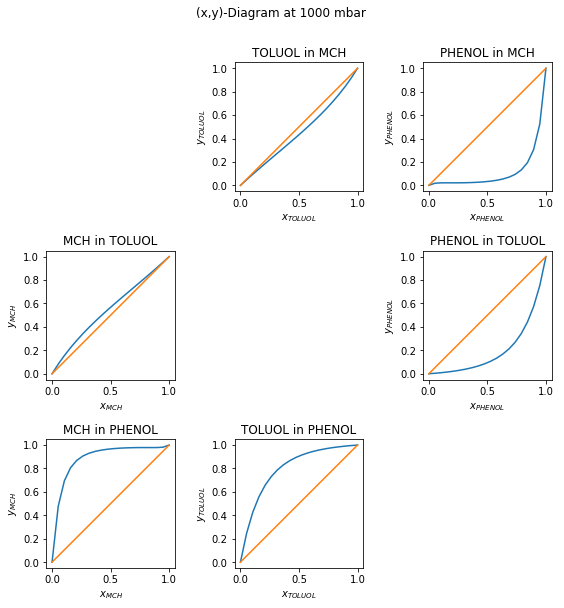

In [7]:
thermoAnalysis(1000)

# Azeotropic column
<div style="width:100%;height:6px;background-color:Black;"></div>

In [8]:
Feed = (MaterialStream("Feed", sys)
        .Specify("T",25, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n[MCH]",90, kmolh)
        .Specify("n[TOLUOL]", 90, kmolh)
        .Specify("n[PHENOL]", 0, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

Recycle = (MaterialStream("Recycle", sys)
        .Specify("T",151, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n[MCH]",0, kmolh)
        .Specify("n[TOLUOL]", 0.1, kmolh)
        .Specify("n[PHENOL]", 250, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

S01 = MaterialStream("S01", sys)
S02 = MaterialStream("S02", sys)
S03 = (MaterialStream("S03", sys)
        .Init("T", 101, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",719, kmolh)
        .Init("n[TOLUOL]", 6, kmolh)
        .Init("n[PHENOL]", 0.1, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

S04 = MaterialStream("S04", sys)
S05 = (MaterialStream("S05", sys)
        .Init("T", 150, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",0, kmolh)
        .Init("n[TOLUOL]", 450, kmolh)
        .Init("n[PHENOL]", 179, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

MCH = MaterialStream("MCH", sys)
B1 = MaterialStream("B1", sys)

C1 = (EquilibriumStageSection("C1",sys,39)
        .Connect("VIn", S05)
        .Connect("LIn", S03)
        .Connect("VOut", S01)
        .Connect("LOut", S04)
        .ConnectFeed(Feed,25)
        .ConnectFeed(Recycle,10)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize())

REB1 = (Flash("REB1",sys)
        .Connect("In", S04)
        .Connect("Vap", S05)
        .Connect("Liq", B1)
        .Specify("P", 1, METRIC.bar)
        .Specify("VF",0.65)
        .Initialize())

COND1 = (Heater("COND1",sys)
        .Connect("In", S01)
        .Connect("Out", S02)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0)\
        .Initialize())

RefluxRatio1=4.7
REFSPL1 = (Splitter("REFSPL1",sys)\
        .Connect("In", S02)\
        .Connect("Out1", MCH)\
        .Connect("Out2", S03)\
        .Specify("DP",0, METRIC.bar)\
        .Specify("K",1-RefluxRatio1/(1.0+RefluxRatio1))\
        .Initialize())
C1.Initialize()

flowsheet= (Flowsheet("Flow")
        .AddMaterialStreams(Feed, Recycle, S01,S02,S03,B1,S04,S05, MCH)
        .AddUnits(C1, REB1, COND1, REFSPL1))

In [9]:
decomp(flowsheet)
decomp(flowsheet)

Decomposition Result: V=882, E=882, Blocks=253, Singletons=245
Block Statistics:
   # Var # Blocks % Blocks
       1      245  96,84 %
       7        4   1,58 %
       8        3   1,19 %
     585        1   0,40 %
Solving problem Subproblem 89 (Size: 585) failed!
The 10 most problematic constraints are:
TraySection          C1                                   0,41411424 ( EQ000434 >> 0 := (V[15] * HV[15] + L[13] * HL[13] + F[14] * HF[14] + Q[14]) / 1000 - ((1 + RV[14]) * V[14] * HV[14] + (1 + RL[14]) * L[14] * HL[14]) / 1000 = 0,414114240291383 )
TraySection          C1                                   0,41282102 ( EQ000448 >> 0 := (V[16] * HV[16] + L[14] * HL[14] + F[15] * HF[15] + Q[15]) / 1000 - ((1 + RV[15]) * V[15] * HV[15] + (1 + RL[15]) * L[15] * HL[15]) / 1000 = 0,412821016447651 )
TraySection          C1                                   0,40961828 ( EQ000420 >> 0 := (V[14] * HV[14] + L[12] * HL[12] + F[13] * HF[13] + Q[13]) / 1000 - ((1 + RV[13]) * V[13] * HV[13] + (1 + R

In [10]:
reporter.Report(flowsheet,5,False)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              25.0000     151.0000     101.6468     101.4339     101.4338
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -36880.0451  -32748.4198   11111.8634  -20705.0401  -20705.0401
Phase                                      Liquid       Liquid       Liquid  BubblePoint       Liquid
Density                   kmol/cum         8.5211      10.1764       0.0321       7.4235       7.4220
Mass Density              kg/cum         810.8851     957.7049       3.1008     717.3268     717.1739
Volume Flow               cum/h           21.1241      24.5765   21528.4542      93.0620      76.7

# Stripping column
<div style="width:100%;height:6px;background-color:Black;"></div>

In [11]:
S06 = MaterialStream("S06", sys)
S07 = MaterialStream("S07", sys)
S08 = (MaterialStream("S08", sys)
        .Init("T", 110, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",1, kmolh)
        .Init("n[TOLUOL]", 400, kmolh)
        .Init("n[PHENOL]", 10, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

S09 = MaterialStream("S09", sys)

S10 = (MaterialStream("S10", sys)
        .Init("T", 180, METRIC.C)
        .Init("P", 1, METRIC.bar)
        .Init("n[MCH]",1, kmolh)
        .Init("n[TOLUOL]", 1, kmolh)
        .Init("n[PHENOL]", 300, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

Toluol = MaterialStream("Toluol", sys)
B2 = MaterialStream("B2", sys)

C2 = (EquilibriumStageSection("C2",sys,19)
        .Connect("VIn", S10)
        .Connect("LIn", S08)
        .Connect("VOut", S06)
        .Connect("LOut", S09)
        .ConnectFeed(B1,12)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize())

REB2 = (Flash("REB2",sys)
        .Connect("In", S09)
        .Connect("Vap", S10)
        .Connect("Liq", B2)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0.4)
        .Initialize())

COND2 = (Heater("COND2",sys)
    .Connect("In", S06)
    .Connect("Out", S07)
    .Specify("P",1, METRIC.bar)
    .Specify("VF",0)
    .Initialize())

RefluxRatio2=2.9
REFSPL2 = (Splitter("REFSPL2",sys)
    .Connect("In", S07)
    .Connect("Out1", Toluol)
    .Connect("Out2", S08)
    .Specify("DP",0, METRIC.bar)
    .Specify("K",0.47)
    .Initialize())

C2.Initialize()
#REB2.Initialize()
#COND2.Initialize()
#REFSPL2.Initialize()
logger.Flush()

flowsheet.AddMaterialStreams(S06,S07,S08,B2,S09,S10,Toluol).AddUnits(C2, REB2, COND2, REFSPL2);

In [12]:
decomp(flowsheet)

Decomposition Result: V=1425, E=1425, Blocks=439, Singletons=425
Block Statistics:
   # Var # Blocks % Blocks
       1      425  96,81 %
       7        6   1,37 %
       8        6   1,37 %
     325        1   0,23 %
     585        1   0,23 %
Problem Flow was successfully solved (0,361 seconds)



# Reach Design Specifications: Purities
<div style="width:100%;height:6px;background-color:Black;"></div>

In [13]:
REB1.Unspecify("VF")
MCH.GetVariable("x[MCH]").Fix(0.99)

decomp(flowsheet)

Decomposition Result: V=1425, E=1425, Blocks=434, Singletons=420
Block Statistics:
   # Var # Blocks % Blocks
       1      420  96,77 %
       7        6   1,38 %
       8        6   1,38 %
     325        1   0,23 %
     590        1   0,23 %
Problem Flow was successfully solved (0,670 seconds)



In [14]:
REB2.Unspecify("VF")
Toluol.GetVariable("x[TOLUOL]").Fix(0.99)

decomp(flowsheet)

Decomposition Result: V=1425, E=1425, Blocks=429, Singletons=415
Block Statistics:
   # Var # Blocks % Blocks
       1      415  96,74 %
       7        6   1,40 %
       8        6   1,40 %
     330        1   0,23 %
     590        1   0,23 %
Problem Flow was successfully solved (0,116 seconds)



# Close Recycle loop
<div style="width:100%;height:6px;background-color:Black;"></div>

In [15]:
Recycle.Unfix()
Makeup = (MaterialStream("Makeup", sys)
        .Specify("T",104, METRIC.C)
        .Specify("P",1, METRIC.bar)
        .Specify("n[MCH]",0, kmolh)
        .Specify("n[TOLUOL]", 0, kmolh)
        .Init("n[PHENOL]", 0.03, kmolh)
        .InitializeFromMolarFlows()
        .FlashPT())

MIX01 = (Mixer("MIX01",sys)
    .Connect("In", B2)
    .Connect("In", Makeup)
    .Connect("Out", Recycle)
    .Specify("DP",0, METRIC.bar)
    .Initialize())

flowsheet.AddMaterialStream(Makeup).AddUnit(MIX01)
Recycle.GetVariable("n").Fix(251/3.6)

In [16]:
calc(flowsheet,1.00,5)
decomp(flowsheet)

Iter Step Length     Infeasibility   Damping Notes
0    0               146,294         1       
1    1365,18         146,294         1       No pivot element found. | SD
2    1365,18         146,044         1       No pivot element found. | SD
3    1363,07         146,037         0,0174453156418813 No pivot element found. | SD
4    1363,38         146,03          0,0170004778459148 No pivot element found. | SD
5    1712,03         146,026         0,00891836917517298 No pivot element found. | SD
Maximum number of iterations exceeded!

Decomposition Result: V=1458, E=1458, Blocks=417, Singletons=406
Block Statistics:
   # Var # Blocks % Blocks
       1      406  97,36 %
       7        3   0,72 %
       8        7   1,68 %
     975        1   0,24 %
Problem Flow was successfully solved (0,959 seconds)



# Print Results
<div style="width:100%;height:6px;background-color:Black;"></div>

In [17]:
reporter.Report(flowsheet,5,False)
print(logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              25.0000     180.4323     100.4252     100.4183     100.4183
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -36880.0451  -25842.7972   11590.0215  -19609.6324  -19609.6324
Phase                                      Liquid       Liquid  LiquidVapor  BubblePoint       Liquid
Density                   kmol/cum         8.5211       9.8638       0.0322       7.1182       7.1182
Mass Density              kg/cum         810.8851     928.2735       3.1592     698.4871     698.4843
Volume Flow               cum/h           21.1241      25.4467   16079.6881      72.7269      59.9

# Column Profiles
## Azeotropic Column

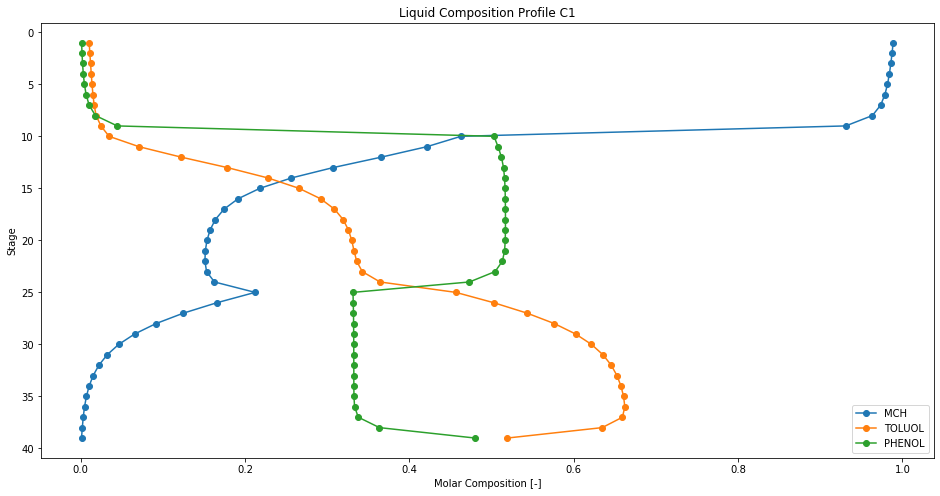

In [18]:
x={}
x["MCH"]=C1.GetProfile("x","MCH")
x["TOLUOL"]=C1.GetProfile("x","TOLUOL")
x["PHENOL"]=C1.GetProfile("x","PHENOL")

stages= range(1, C1.NumberOfTrays+1)
df_comp= pd.DataFrame(zip(x["MCH"],x["TOLUOL"],x["PHENOL"] ), 
                      index=stages, 
                      columns=sys.GetComponentIds())

plt.plot( df_comp["MCH"], stages, linestyle='-', marker='o')
plt.plot( df_comp["TOLUOL"], stages, linestyle='-', marker='o')
plt.plot( df_comp["PHENOL"], stages, linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.legend(sys.GetComponentIds())
plt.xlabel("Molar Composition [-]")
plt.ylabel("Stage")
plt.title("Liquid Composition Profile C1");

In [19]:
reporter.Report(C1,True)
print(logger.Flush())

     Stage          T         TV          P          Q          L          V          F          W         RL        EPS
                   °C         °C        bar         MW     kmol/h     kmol/h     kmol/h     kmol/h                   [-]
1             100,425    100,425      1,000      0,000    426,722    517,685    426,863      0,000      0,000      1,000
2             100,434    100,434      1,000      0,000    426,545    517,543      0,000      0,000      0,000      1,000
3             100,444    100,444      1,000      0,000    426,315    517,367      0,000      0,000      0,000      1,000
4             100,459    100,459      1,000      0,000    426,001    517,137      0,000      0,000      0,000      1,000
5             100,479    100,479      1,000      0,000    425,546    516,823      0,000      0,000      0,000      1,000
6             100,510    100,510      1,000      0,000    424,834    516,368      0,000      0,000      0,000      1,000
7             100,564    100,564

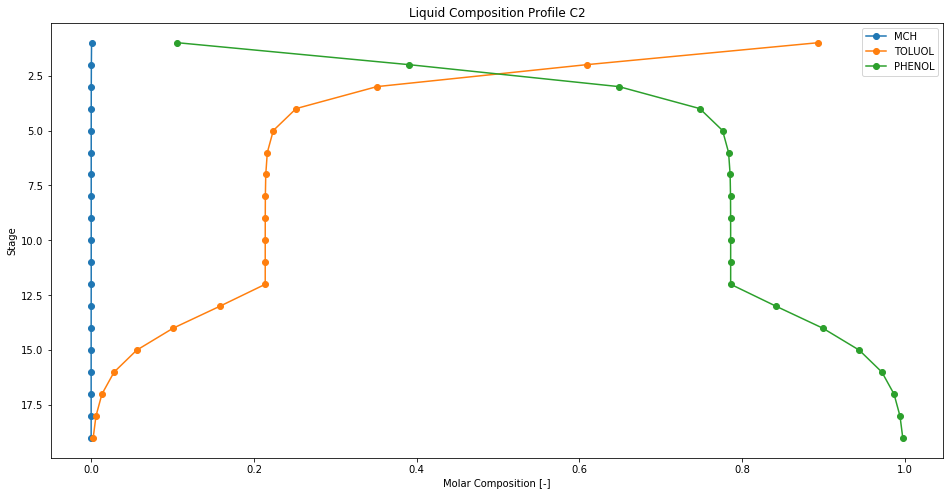

In [20]:
x={}
x["MCH"]=C2.GetProfile("x","MCH")
x["TOLUOL"]=C2.GetProfile("x","TOLUOL")
x["PHENOL"]=C2.GetProfile("x","PHENOL")

stages= range(1, C2.NumberOfTrays+1)
df_comp= pd.DataFrame(zip(x["MCH"],x["TOLUOL"],x["PHENOL"] ), 
                      index=stages, 
                      columns=sys.GetComponentIds())

plt.plot( df_comp["MCH"], stages, linestyle='-', marker='o')
plt.plot( df_comp["TOLUOL"], stages, linestyle='-', marker='o')
plt.plot( df_comp["PHENOL"], stages, linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.legend(sys.GetComponentIds())
plt.xlabel("Molar Composition [-]")
plt.ylabel("Stage")
plt.title("Liquid Composition Profile C2");

In [21]:
reporter.Report(C2,True)
print(logger.Flush())

     Stage          T         TV          P          Q          L          V          F          W         RL        EPS
                   °C         °C        bar         MW     kmol/h     kmol/h     kmol/h     kmol/h                   [-]
1             113,479    113,479      1,000      0,000     89,662    191,604    101,550      0,000      0,000      1,000
2             125,556    125,556      1,000      0,000     73,932    179,716      0,000      0,000      0,000      1,000
3             141,649    141,649      1,000      0,000     67,497    163,986      0,000      0,000      0,000      1,000
4             150,024    150,024      1,000      0,000     66,298    157,550      0,000      0,000      0,000      1,000
5             152,698    152,698      1,000      0,000     66,093    156,352      0,000      0,000      0,000      1,000
6             153,425    153,425      1,000      0,000     66,050    156,147      0,000      0,000      0,000      1,000
7             153,615    153,615

# Block Flow Diagram

In [22]:
from IPython.display import Image as render

def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 

In [23]:
C1.SetIcon(IconTypes.ColumnSection, 300,260).SetColors("Green","White")
REB1.SetIcon(IconTypes.TwoPhaseFlash, 380,500)
COND1.SetIcon(IconTypes.Heater, 380,120)
REFSPL1.SetIcon(IconTypes.Splitter, 510,190)
C2.SetIcon(IconTypes.ColumnSection, 790,270).SetColors("OrangeRed","White")
REB2.SetIcon(IconTypes.TwoPhaseFlash, 890,540)
COND2.SetIcon(IconTypes.Heater, 890,120)
REFSPL2.SetIcon(IconTypes.Splitter, 1070,190)
MIX01.SetIcon(IconTypes.Mixer, 170,440)
Feed.SetIcon(IconTypes.Stream, 10,340)
MCH.SetIcon(IconTypes.Stream, 620,120)
Toluol.SetIcon(IconTypes.Stream, 1160,120)
Makeup.SetIcon(IconTypes.Stream, 10,440)

sheet1=(SpreadsheetElement("Results")
    .SetIcon(IconTypes.Spreadsheet, 980,360)
    .SetSize(400,400)
    .AddVariable(REB1.GetVariable("Q"))
    .AddVariable(COND1.GetVariable("Q"))
    .AddVariable(REB2.GetVariable("Q"))
    .AddVariable(COND2.GetVariable("Q"))
    .AddVariable(REFSPL1.GetVariable("K"))
    .AddVariable(REFSPL2.GetVariable("K"))
    .AddVariable(REB1.GetVariable("VF"))
    .AddVariable(REB2.GetVariable("VF"))
       )

flowsheet.AddDocumentation(sheet1)

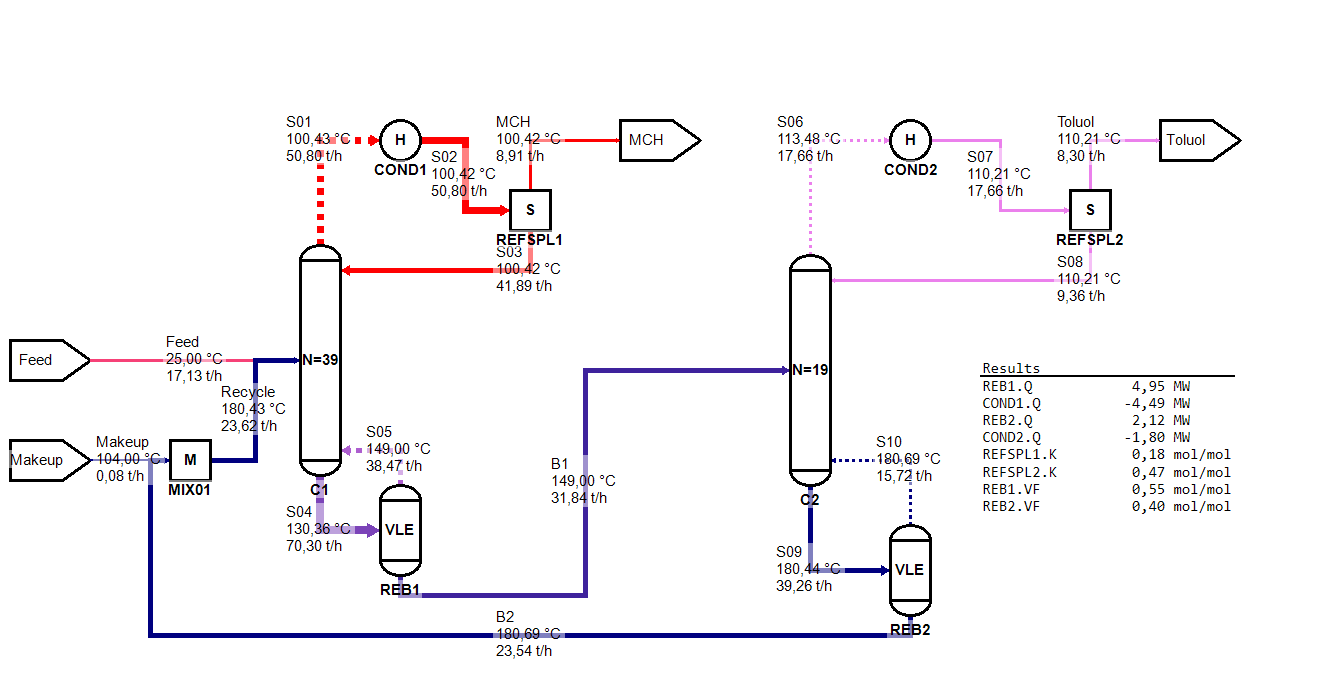

In [24]:
options=DrawingOptions()
options.ShowStreamWidth=True
options.ShowPressure=False
options.ShowTemperature=True
options.ShowStreamColors=True
options.ColorMap["MCH"]="Red"
options.ColorMap["TOLUOL"]="Violet"
options.ColorMap["PHENOL"]="Navy"
render(convertFlowsheet(flowsheet,options))